In [43]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

100.0%

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
os.listdir('./data/cifar10/train')

['cat',
 'dog',
 'truck',
 'bird',
 'airplane',
 'ship',
 'frog',
 'horse',
 'deer',
 'automobile']

In [8]:
airplane_files = os.listdir('./data/cifar10/train/airplane')

In [14]:
dataset = ImageFolder('./data/cifar10/train', transform=ToTensor())

In [16]:
img, label = dataset[0]

In [23]:
print(img.shape, label)
print(dataset.classes)
img


torch.Size([3, 32, 32]) 0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

In [29]:
def show_example(img, label):
    print(f"Label: {dataset.classes[label]}, ({str(label)})")
    plt.imshow(img.permute(1,2,0))

Label: airplane, (0)


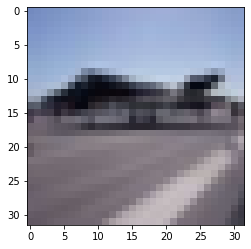

In [31]:
show_example(*dataset[1])

In [33]:
def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [34]:
val_pct = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))

40000 10000


In [38]:
batch_size = 100
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size, sampler=val_sampler)

In [41]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break

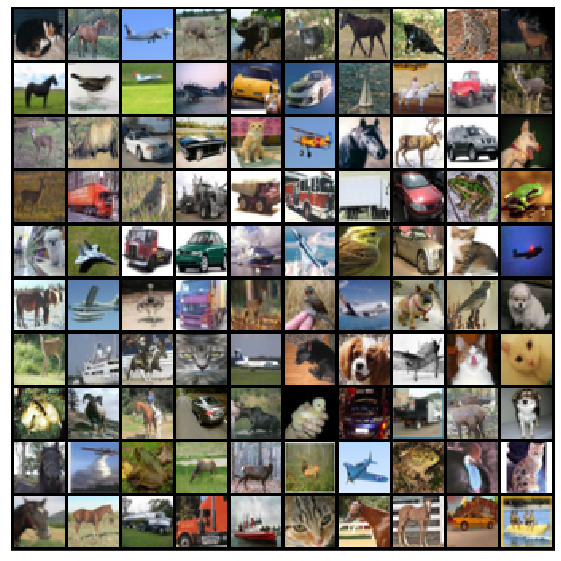

In [42]:
show_batch(train_dl)

## Model

In [45]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [46]:
for images, labels in train_dl:
    print(images.shape)
    out = simple_model(images)
    print(out.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 8, 16, 16])


In [48]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #op: 16x16x16

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op: 16x8x8
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 16x4x4

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 16x2x2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 16x1x1
    nn.Flatten(), #16
    nn.Linear(16, 10) #op: 10 classes
)

In [49]:
for images, labels in train_dl:
    print(images.shape)
    out = model(images)
    print(out.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 10])


In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [54]:
device = get_default_device()

In [56]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=16, out_features=10, bias=True)
)

## Training the model

In [58]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    return loss.item(), len(yb), metric_result

In [59]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [66]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        model.train()
        for xb,yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:4f}, val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss, 
                          metric.__name__, val_metric))
    return train_losses, val_losses, val_metrics

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [63]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3131, Accuracy: 0.1034


In [64]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [67]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, valid_dl, opt_fn, lr, accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], train_loss: 1.7036, val_loss: 1.6875, val_accuracy: 0.3689
Epoch [2/10], train_loss: 1.4177, val_loss: 1.5350, val_accuracy: 0.4424
Epoch [3/10], train_loss: 1.2661, val_loss: 1.4428, val_accuracy: 0.4725
Epoch [4/10], train_loss: 1.5430, val_loss: 1.4445, val_accuracy: 0.4677
Epoch [5/10], train_loss: 1.4302, val_loss: 1.4016, val_accuracy: 0.4918
Epoch [6/10], train_loss: 1.3845, val_loss: 1.3425, val_accuracy: 0.5146
Epoch [7/10], train_loss: 1.4021, val_loss: 1.3550, val_accuracy: 0.5049
Epoch [8/10], train_loss: 1.4026, val_loss: 1.3112, val_accuracy: 0.5188
Epoch [9/10], train_loss: 1.2612, val_loss: 1.2979, val_accuracy: 0.5320
Epoch [10/10], train_loss: 1.4400, val_loss: 1.3326, val_accuracy: 0.5212


In [68]:
test_dataset = ImageFolder('./data/cifar10/test', transform=ToTensor())

In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: automobile


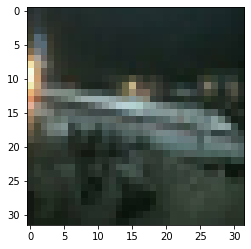

In [70]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))